In [1]:
pip install hazm

     |████████████████████████████████| 317kB 7.6MB/s 
     |████████████████████████████████| 235kB 52.4MB/s 
     |████████████████████████████████| 1.4MB 18.0MB/s 
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154172 sha256=bda4717dafd932615c19342e164d1c7d6770185bc669f35b00a6ff438891e678
  Stored in directory: /root/.cache/pip/wheels/66/15/54/4510dce8bb958b1cdd2c47425cbd1e1eecc0480ac9bb1fb9ab
  Created wheel for nltk: filename=nltk-3.3-cp37-none-any.whl size=1394485 sha256=5f40048331dcd637f828d05d9933f60c3e0a419200e361fefc4de05cfeaa2e45
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built libwapiti nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
! pip install -q pyonmttok

     |████████████████████████████████| 14.3MB 196kB/s 


# **Processing Data with torchtext**

In [24]:
import pandas as pd
import spacy
import numpy as np
import torch 
import requests
from nltk import word_tokenize
import nltk
from hazm import *
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from sklearn.model_selection import train_test_split
import math
import pyonmttok
import torch
import torch.nn as nn

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/DL_4"

In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/DL_4/AFEC-merged-all.zip" -d "//content/drive/My Drive/Colab Notebooks/DL_4/AFEC-merged-all"

In [ ]:
!unzip "/content/drive/My Drive/Colab Notebooks/DL_4/Test.zip" -d "//content/drive/My Drive/Colab Notebooks/DL_4/Test"

In [6]:
english_text = open('/content/drive/My Drive/Colab Notebooks/DL_4/AFEC-merged-all/AFEC-merged.en', encoding='utf8').read().split('\n')
persian_text = open('/content/drive/My Drive/Colab Notebooks/DL_4/AFEC-merged-all/AFEC-merged.fa', encoding='utf8').read().split('\n')

In [22]:
data = {'English': [line for line in english_text],
        'Persian': [line for line in persian_text ]}

In [ ]:
df = pd.DataFrame(data ,  columns = ['English' , 'Persian'])

In [ ]:
train , validation = train_test_split(df , test_size = 0.1)

In [ ]:
train.to_json(r'/content/drive/My Drive/Colab Notebooks/DL_4/train.json',orient='records' , lines =True)
validation.to_json(r'/content/drive/My Drive/Colab Notebooks/DL_4/validation.json',orient='records' , lines =True)

"train.to_json(r'/content/drive/My Drive/Colab Notebooks/DL_4/train.json',orient='records' , lines =True)\nvalidation.to_json(r'/content/drive/My Drive/Colab Notebooks/DL_4/validation.json',orient='records' , lines =True)"

In [7]:
tokenizer = pyonmttok.Tokenizer("aggressive", joiner_annotate = True , segment_numbers = True)
learner_eng = pyonmttok.BPELearner(tokenizer = tokenizer , symbols = 3200)
learner_per = pyonmttok.BPELearner(tokenizer = tokenizer , symbols = 3200)

In [8]:
#english words
for i in range(len(english_text)):
    learner_eng.ingest(english_text[i])

In [9]:
#persian wors
for i in range(len(persian_text)):
    learner_per.ingest(persian_text[i])

In [10]:
path_eng = "/content/drive/My Drive/Colab Notebooks/DL_4/model_english"
tokenizer_eng = learner_eng.learn(path_eng)

In [12]:
path_per = "/content/drive/My Drive/Colab Notebooks/DL_4/model_persian"
tokenizer_per = learner_per.learn(path_per)

In [13]:
with open(path_eng) as model:
    assert model.read() 

def tokenizer_english(text):
  tokens, _ = tokenizer_eng.tokenize(text)
  return tokens

tokenizer_english(english_text[0])

['North', 'Waziristan', 'operation', 'kills', '5￭', '0', 'more', 'militants']

In [14]:
with open(path_per) as model:
    assert model.read() 
    
def tokenizer_persian(text):
  tokens ,_ = tokenizer_per.tokenize(text)
  return tokens
tokenizer_persian(persian_text[0])

['مرگ', '5￭', '0', 'ستیزه', 'جوی', 'دیگر', 'در', 'عملیات', 'وزیرستان', 'شمالی']

In [15]:
#Defines a datatype together with instructions for converting to Tensor.
#sequentila -> if false no tokenize applied.
#use_vocab : if false data already is numercal.

english = Field(sequential = True , use_vocab = True ,init_token = '<sos>', eos_token = '<eos>',  batch_first = True, tokenize = tokenizer_english , lower = True)
persian = Field(sequential = True , use_vocab = True ,init_token = '<sos>', eos_token = '<eos>',  batch_first = True, tokenize = tokenizer_persian , lower = True)

            

In [16]:
fields = {'English' : ('english',english), 'Persian' : ('persian',persian)}

In [17]:
#Defines a Dataset of columns stored in CSV, TSV, or JSON format.
train_data , validation_data = TabularDataset.splits(
    path = '/content/drive/My Drive/Colab Notebooks/DL_4/',
    train = 'train.json',
    validation = 'validation.json',
    format = 'json',
    fields = fields
)

In [18]:
english.build_vocab(train_data , min_freq = 6)
persian.build_vocab(train_data , min_freq = 6)

In [19]:
len(english.vocab)

3062

In [20]:
train_iterator , validation_iterator = BucketIterator.splits(
    (train_data,validation_data),
    batch_size = 64,
    device='cuda',
    sort = False
)

Test **Data**

In [21]:
english_test_text = open('/content/drive/My Drive/Colab Notebooks/DL_4/Test/Test/test.en', encoding='utf8').read().split('\n')
persian_test_text_0 = open('/content/drive/My Drive/Colab Notebooks/DL_4/Test/Test/test.fa0', encoding='utf8').read().split('\n')
persian_test_text_1 = open('/content/drive/My Drive/Colab Notebooks/DL_4/Test/Test/test.fa1', encoding='utf8').read().split('\n')
persian_test_text_2 = open('/content/drive/My Drive/Colab Notebooks/DL_4/Test/Test/test.fa2', encoding='utf8').read().split('\n')
persian_test_text_3 = open('/content/drive/My Drive/Colab Notebooks/DL_4/Test/Test/test.fa3', encoding='utf8').read().split('\n')

# **Network**

In [25]:
class SelfAttention(nn.Module):
  def __init__(self ,embed_size , heads):
    super(SelfAttention , self).__init__()
    self.embed_size = embed_size
    self.heads = heads
    self.heads_dim = embed_size //heads
    #print(self.heads_dim)

    assert self.heads_dim*heads == embed_size ,"Embed size need to be div by heads"

    """self.values = nn.Linear(self.heads_dim , self.heads_dim , bias = False)
    self.keys = nn.Linear(self.heads_dim , self.heads_dim ,bias = False)
    self.queries = nn.Linear(self.heads_dim ,self.heads_dim , bias =False)"""

    self.values = nn.Linear(self.embed_size , self.embed_size , bias = False)
    self.keys = nn.Linear(self.embed_size , self.embed_size ,bias = False)
    self.queries = nn.Linear(self.embed_size ,self.embed_size , bias =False)
    self.fc_out = nn.Linear(heads*self.heads_dim , embed_size) #embed_size = heads*heads_dim


  def forward(self , values , keys , queries , mask):
    #number of training examples /how many example we are sending at the same time
    N = queries.shape[0]
    value_len , key_len , query_len = values.shape[1] , keys.shape[1] ,queries.shape[1] #these length coresspond to target and sourcr sentences length.
    

    values = self.values(values)
    #print("after values",values.shape)
    keys = self.keys(keys)
    #print("keys",keys.shape)
    queries = self.queries(queries)
    #print("queries" ,queries.shape)

    #split embeddig into self.heads pieses
    values = values.reshape(N , value_len , self.heads , self.heads_dim) # split embed_size into self.heads and self.heads_dim
    #print("values",values.shape)
    keys = keys.reshape(N , key_len , self.heads , self.heads_dim)
    queries = queries.reshape(N , query_len , self.heads , self.heads_dim)

    energy = torch.einsum("bqhd,bkhd -> bhqk" , [queries,keys])
    #queiries shape: (N,query_len , heads , heads_dim)
    #keys shape : (N , key_len ,heads ,heads_dim)
    #energy shape : (N, heads , query_len , key_len) #query = target , key = source
    #print("energy",energy.shape)
    if mask is not None:
      #print("####mask",mask.shape)
      #print("energy",energy.shape)
      #mask = mask.unsqueeze(1).unsqueeze(2)
      #print("mask",mask.shape)
      mask = mask.unsqueeze(1).unsqueeze(2)
      energy = energy.masked_fill(mask == True , float("-1e20"))#if a element of a mask is zero it means that shut that off
      #print("energy after mask",energy.shape)
    #key_length = value_length
    attention = torch.softmax(energy / (self.embed_size **(1/2)) , dim=2)
    #print("attention",attention.shape)
    out = torch.einsum("bhql,blhd->bqhd",[attention,values]).reshape(N,query_len,self.heads*self.heads_dim)
    #print("out",out.shape)
    #attention shape :(batch,heads ,query_len ,key_len)
    #values shape :(bach) ,value_len ,heads,head_dim)
    #after einsum(batch,query_len,heads,head_dim) then flatten last two dimention

    out = self.fc_out(out)
    #print("selfattention")
    return out

In [26]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size , embed_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embed_size = embed_size

    def forward(self, tokens):

        #print(":tokenembedding")
        return self.embedding(tokens) * math.sqrt(self.embed_size)

In [27]:
#https://pytorch.org/tutorials/beginner/translation_transformer.html
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size , maxlen = 500):
        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, embed_size, 2)* math.log(10000) / embed_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, embed_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding ):
        #print("positional_encoding")
        return self.pos_embedding[:token_embedding.size(0), :]

In [28]:
class TransformerBlock(nn.Module):
  def __init__(self,embed_size,heads,dropout,dim_inner):
    super(TransformerBlock,self).__init__()
    self.attention = SelfAttention(embed_size,heads)
    self.norm1 = nn.LayerNorm(embed_size)
    self.norm2 = nn.LayerNorm(embed_size)

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size,dim_inner),
        nn.ReLU(),
        nn.Linear(dim_inner,embed_size)
    
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self,value , key, query, mask):
    attention = self.attention(value,key,query,mask)

    x = self.dropout(self.norm1(attention+query))
    forward = self.feed_forward(x)
    out = self.dropout(self.norm2(forward + x))
    #print("transformerblock")
    return out

In [29]:
class Encoder(nn.Module):
  def __init__(self,
               src_vocab_size, 
               embed_size, 
               num_layers,
               heads, 
               dim_inner,
               device,
               dropout,
               max_length, #positional emedding how long is the sentence length
  ):
    super(Encoder,self).__init__()
    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(src_vocab_size , embed_size)
    self.position_embedding = PositionalEncoding( embed_size ,max_length)

    self.encoder_layers = nn.ModuleList(
        [
         TransformerBlock(
             embed_size,
             heads,
             dropout = dropout,
             dim_inner = dim_inner
         )
         for _ in range(num_layers)
        ]
    )
    self.dropout = nn.Dropout(dropout)
  
  def forward(self , x , mask):
    N, seq_length = x.shape
    word_embedding = self.word_embedding(x)
    pos_embedding = self.position_embedding(word_embedding)
    out = self.dropout(word_embedding+pos_embedding)

    for layer in self.encoder_layers:
      out = layer(out , out , out, mask)
    #print("out",out.shape)
    #print("encoder")
    return out

In [30]:
class Decoder(nn.Module):
  def __init__(self, embed_size, heads, num_layers ,trg_vocab_size,max_length ):
    super(Decoder,self).__init__()
    
    self.embed_size = embed_size
    self.dropout = nn.Dropout(0.1)
    #self.device = device
    self.decoder_layers = nn.ModuleList(
        [
         nn.TransformerDecoderLayer(
             d_model = embed_size,
             nhead = heads,
             batch_first = True
         )
         for _ in range(num_layers)
        ]
    )
    self.word_embedding = nn.Embedding(trg_vocab_size , embed_size)
    self.position_embedding = PositionalEncoding( embed_size ,max_length)
    self.fc_out = nn.Linear(embed_size, trg_vocab_size) 

  def forward(self , target , encoder_src, target_mask ,padding_mask ):

    word_embedding = self.word_embedding(target)
    pos_embedding = self.position_embedding(target)
    out = self.dropout(word_embedding+pos_embedding)


    for layer in self.decoder_layers:
      out = layer( out, encoder_src ,tgt_mask  = target_mask ,tgt_key_padding_mask = padding_mask)
    #print("decoder")
    out = self.fc_out(out)

    return out

In [32]:
class Transformer(nn.Module):
  def __init__(
      self, 
      encoder, 
      decoder, 
      src_pad_idx, 
      trg_pad_idx, 
      device
  ):
      super(Transformer , self).__init__()
      self.encoder = encoder
      self.decoder = decoder
      self.src_pad_idx = src_pad_idx
      self.trg_pad_idx = trg_pad_idx
      self.device = device
      self.pad_trg_idx = persian.vocab.stoi['<pad>']
      self.pad_src_idx = english.vocab.stoi['<pad>']


  def create_trg_mask(self ,tgt):
      N , l = tgt.shape
      mask = (torch.triu(torch.ones((l, l),device=self.device)) == 1).transpose(0, 1)
      mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
      return mask.to(self.device)

  def create_trg_padding_mask(self , tgt):
    N , tgt_seq_len = tgt.shape
    tgt_padding_mask = (tgt == self.pad_trg_idx)
    return tgt_padding_mask.to(self.device)

  def create_src_padding_mask(self , src):
      src_seq_len = src.shape[1]
      src_padding_mask = (src == self.pad_src_idx)
      #src_mask = torch.zeros((src_seq_len, src_seq_len),device=self.device).type(torch.bool)
      return src_padding_mask.to(self.device)
      

  def forward(self, src, trg):

      trg_mask =self.create_trg_mask(trg)
      trg_mask.shape
      trg_padding_mask =self.create_trg_padding_mask(trg)
      trg_padding_mask.shape
      src_padding_mask =self.create_src_padding_mask(src)
      src_padding_mask.shape

      enc_src = self.encoder(src, src_padding_mask)
      out = self.decoder(trg, enc_src,trg_mask, trg_padding_mask)
      #print("transformer")
      return out

      

In [33]:
src_vocab_size = len(english.vocab)
trg_vocab_size = len(persian.vocab)
per_pad_idx = persian.vocab.stoi[persian.pad_token]
eng_pad_idx = english.vocab.stoi[english.pad_token]
embed_size = 256
num_layers_enc = 3
num_layers_dec = 3
heads_enc = 8
heads_dec = 8
dim_inner = 1024
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dropout = 0.1
max_length = 500

encoder = Encoder(
      src_vocab_size, 
      embed_size, 
      num_layers_enc, 
      heads_enc, 
      dim_inner,
      device,
      dropout,
      max_length)

decoder = Decoder(
        embed_size,
        heads_dec,
        num_layers_dec,
        trg_vocab_size,
        max_length,
        #batch_first = True
    )

model = Transformer(encoder, decoder, per_pad_idx, eng_pad_idx, device).to(device)

In [ ]:
#model.to(device)

In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,645,668 trainable parameters


In [36]:
LearningRate = 0.0001

In [ ]:
LearningRate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = LearningRate,betas=(0.9, 0.98), eps=1e-09)

criterion = nn.CrossEntropyLoss(ignore_index = per_pad_idx)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(validation_iterator):

            src = batch.english.to(device)
            trg = batch.persian.to(device)



            output = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

9625

In [ ]:
def train(model, train_iterator,validation_iterator, optimizer, criterion, clip):

    PATH = '/content/drive/My Drive/Colab Notebooks/DL4_part2_v1.pth'
    model.train()
    
    loss_train = []
    loss_val = []

    iter_loss = 0
    L = len(train_iterator)
    flag = False
    count_iter = 0

    count_iter = 0
    for epoch in range(10):
        for i, batch in enumerate(train_iterator):
            count_iter +=1

            src = batch.english.to(device)
            trg = batch.persian.to(device)
            
            optimizer.zero_grad()
            
            output = model(src, trg[:,:-1]) #except last one
                    
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
                
            output_dim = output.shape[-1] #shape akhar
                
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
                    
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
                
            loss = criterion(output, trg)
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
            optimizer.step()
            
            iter_loss += loss.item()
            #iter = epoch*L+i
            if  count_iter%500== 0:
  
              loss_train.append(iter_loss/500)
              temp = evaluate(model,validation_iterator,criterion)
              loss_val.append(temp)
              print("epoch:",epoch+1,"iteration:",count_iter ,"   train loss" ,iter_loss/500 , "   validation loss:",temp)
              iter_loss = 0

            
            if (count_iter) == 30000 :
              flag = True
              break
            else:
              continue
        if flag == True:
          break;
              
        torch.save(model.state_dict(), PATH)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH)
    return model ,loss_train,loss_val

In [ ]:
model , train_loss,val_loss = train(model, train_iterator,validation_iterator, optimizer, criterion, clip=1)

epoch: 1 iteration: 500    train loss 4.084091748714447    validation loss: 3.5374528252075765
epoch: 1 iteration: 1000    train loss 3.320100438117981    validation loss: 3.3407489859055137
epoch: 1 iteration: 1500    train loss 3.27981924200058    validation loss: 3.3155697176389607
epoch: 1 iteration: 2000    train loss 3.2681376576423644    validation loss: 3.2993105291206146
epoch: 1 iteration: 2500    train loss 3.247595808506012    validation loss: 3.2812143111897405
epoch: 1 iteration: 3000    train loss 3.240634624004364    validation loss: 3.2669113475585654
epoch: 1 iteration: 3500    train loss 3.2162125940322874    validation loss: 3.257601042774236
epoch: 1 iteration: 4000    train loss 3.209838613510132    validation loss: 3.2477090846712344
epoch: 1 iteration: 4500    train loss 3.2000886816978453    validation loss: 3.229250258820079
epoch: 1 iteration: 5000    train loss 3.1903098154067995    validation loss: 3.2252975412618334
epoch: 1 iteration: 5500    train loss 3

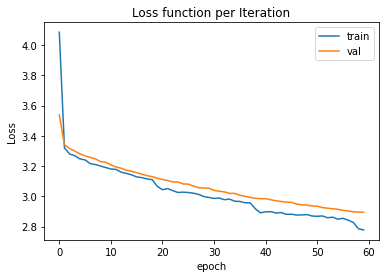

In [59]:
import matplotlib.pyplot as plt
plt.plot(train_loss )
plt.plot(val_loss)
plt.title('Loss function per Iteration')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['train','val']);

In [ ]:
"""PATH = '/content/drive/My Drive/Colab Notebooks/DL4_part2_v1.pth'

model = Transformer(encoder, decoder, per_pad_idx, eng_pad_idx, device)
optimizer = torch.optim.Adam(model.parameters(), lr = LearningRate,betas=(0.9, 0.98), eps=1e-09)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()"""

In [ ]:
#model.to(device)

In [39]:
def translation(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()

    tokens = nltk.word_tokenize(sentence.lower())

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.create_src_padding_mask(src_tensor)
       
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
      

        trg_padding_mask =  model.create_trg_padding_mask(trg_tensor)
        trg_mask =   model.create_trg_mask(trg_tensor)

        
        with torch.no_grad():
            output = model.decoder(trg_tensor, enc_src, trg_mask, trg_padding_mask )
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:]

In [40]:
example_idx = 65
#65, 45 , 154 , 89
def view_sentence(example_idx):
    src = english_test_text[example_idx]
    trg = persian_test_text_0[example_idx]

    print('English(source):' ,"".join(src[:-1]))
    print('persian(target):',"".join(trg[:-1]) )
    predict = translation(src, english, persian, model, device)
    print("predict:" ," ".join(predict[:-1]) )

In [42]:
a = [1 , 102,107,215,65 ,89 , 156,182,18,51]
for i in a:
  view_sentence(i)
  print("\n")

English(source): it is more comfortable by train 
persian(target): با قطار خیلی راحتتر است 
predict: بیشتر از آن بیشتر است .


English(source): would you like to do something in the evening 
persian(target): آیا عصر دوست دارید کاری انجام دهید 
predict: کاری که می￭ کنی انجام ب￭ دهید ?


English(source): okay . goodbye 
persian(target): باشه . خداحافظ 
predict: .


English(source): yes , I would suggest the flight at a quarter past seven 
persian(target): بله ، من پرواز ساعت هفت و ربع را پیشنهاد میکنم 
predict: بله , من در ساعت هفت و یک ساعت در یک ر￭ اس￭ تا هستم .


English(source): I did not understand that 
persian(target): من آن را نفهمیدم 
predict: من آن را ن￭ کردم .


English(source): what is the name of our hotel 
persian(target): نام هتل ما چیست 
predict: اسم ما چه است ?


English(source): yes . is everything okay so far then 
persian(target): بله . پس تا به حال همه چیز مرتب است 
predict: بله , همه چیز بسیار خوب است ? بله .


English(source): fine . let us meet at ten o'clock in t

In [43]:
def make_hypotheses(example_idx):
    src = english_test_text[example_idx]
    trg = persian_test_text_0[example_idx]

    predict = translation(src, english, persian, model, device)
    return (predict[:-1])

In [47]:
#import nltk.tranlate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import corpus_bleu 
from nltk.translate.nist_score import corpus_nist

bleu_2 = []
bleu_3 = []
bleu_4 = []
nist = []

for i in range(len(persian_test_text_0)):
  hypotheses = []
  refrences = []

  hypotheses.append(make_hypotheses(i))
  refrences.append(tokenizer_persian(persian_test_text_0[i]))
  refrences.append(tokenizer_persian(persian_test_text_1[i]))
  refrences.append(tokenizer_persian(persian_test_text_2[i]))
  refrences.append(tokenizer_persian(persian_test_text_3[i]))
  #print(refrences)
  weights = (1./5., 1./5., 1./5., 1./5.)
  bleu_4.append(corpus_bleu([refrences],hypotheses, weights)) 
  weights = (1./5., 1./5., 1./5.)
  bleu_3.append(corpus_bleu([refrences],hypotheses, weights))
  weights = (1./5., 1./5.)
  bleu_2.append(corpus_bleu([refrences],hypotheses, weights)) 
  if i in [5,8,21 , 39 ,46 ,60 , 64 , 69 ,89 ,99 ,107,179,192,216,219,250]:
    continue
  try :
      try :
          nist.append(corpus_nist([refrences],hypotheses)) 
      except  StopIteration:
          nist.append(0)
  except  ZeroDivisionError:
      nist.append(0)


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [48]:
np.mean(bleu_2)

0.33444979059823704

In [49]:
np.mean(bleu_3)

0.13723654610607663

In [50]:
np.mean(bleu_4)

0.03657478465766052

In [51]:
np.mean(nist)

0.9686251403740994